In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path

base_name = "war"

graph_dir = 'graphs'
graph_name = f'{base_name}.pt'
graph_dir = Path(graph_dir)
graph_dir.mkdir(exist_ok=True)
graph_path = graph_dir / graph_name

In [4]:
from pathlib import Path

from circuit_tracer import ReplacementModel, attribute
from circuit_tracer.utils import create_graph_files
from circuit_tracer.utils.create_graph_files import load_graph_data

graph = load_graph_data(graph_path)

In [12]:
from algorithm1 import run_ea_optimization
from experiments.models import EAHyperparameters

hp = EAHyperparameters(
    population_size=50,
    n_generations=100,
    w_completeness = 0.5,
    w_replacement = 1, 
    w_complexity_node = 8.0,
    w_complexity_edge = 4.0
)

result = run_ea_optimization(
  graph, 
  verbose=True, 
  max_batch_per_gpu=8,
  hp=hp,
)

MultiGPUGraphEvaluator initialized with 4 GPUs: [0, 1, 2, 3]
  Max batch per GPU: 8
Precomputing graph influence scores...
Starting NSGA-II Multi-Objective Evolutionary Algorithm...
Initialized population of size 50
Starting NSGA-II Multi-Objective Evolutionary Algorithm...
Initialized population of size 50
Initial evaluation complete.
Sample individual objectives: [1.1578142642974854, 120.41553548664217]
Number of fronts: 8
Front 0 size: 8

=== Generation 1/100 ===
Pareto front size: 8
Best quality individual:
  Rank: 0 | Crowding Distance: inf
  Objectives: Quality=1.1903, Complexity=121.6037
  Completeness: 0.9219 | Replacement: 0.7293
  Nodes: 3833 (log: 8.25) | Edges: 1086118 (log: 13.90)
  Mean Node Threshold: 0.7733 | Mean Edge Threshold: 0.7051
  Overrides: +0/-0 nodes, +0/-0 edges
Initial evaluation complete.
Sample individual objectives: [1.1578142642974854, 120.41553548664217]
Number of fronts: 8
Front 0 size: 8

=== Generation 1/100 ===
Pareto front size: 8
Best quality ind

In [5]:
# evaluate default graph

In [13]:
# Examine NSGA-II results
print(f"Pareto Front Size: {result['pareto_front_size']}")
print()

# Best quality solution (max completeness + replacement)
print("=== Best Quality Solution ===")
bq = result['best_quality']
print(f"  Quality: {bq['quality']:.4f}, Complexity: {bq['complexity']:.4f}")
print(f"  Completeness: {bq['completeness']:.4f}, Replacement: {bq['replacement']:.4f}")
print(f"  Nodes: {bq['n_nodes']}, Edges: {bq['n_edges']}")

# Best complexity solution (min nodes + edges)
print("\n=== Best Complexity Solution ===")
bc = result['best_complexity']
print(f"  Quality: {bc['quality']:.4f}, Complexity: {bc['complexity']:.4f}")
print(f"  Completeness: {bc['completeness']:.4f}, Replacement: {bc['replacement']:.4f}")
print(f"  Nodes: {bc['n_nodes']}, Edges: {bc['n_edges']}")

# Balanced solution (knee point)
print("\n=== Balanced Solution (Knee Point) ===")
bal = result['balanced']
print(f"  Quality: {bal['quality']:.4f}, Complexity: {bal['complexity']:.4f}")
print(f"  Completeness: {bal['completeness']:.4f}, Replacement: {bal['replacement']:.4f}")
print(f"  Nodes: {bal['n_nodes']}, Edges: {bal['n_edges']}")

Pareto Front Size: 15

=== Best Quality Solution ===
  Quality: 1.3413, Complexity: 67.0095
  Completeness: 0.9510, Replacement: 0.8658
  Nodes: 157, Edges: 765

=== Best Complexity Solution ===
  Quality: 1.2903, Complexity: 63.1190
  Completeness: 0.9345, Replacement: 0.8230
  Nodes: 122, Edges: 479

=== Balanced Solution (Knee Point) ===
  Quality: 1.3316, Complexity: 63.5085
  Completeness: 0.9478, Replacement: 0.8577
  Nodes: 126, Edges: 495


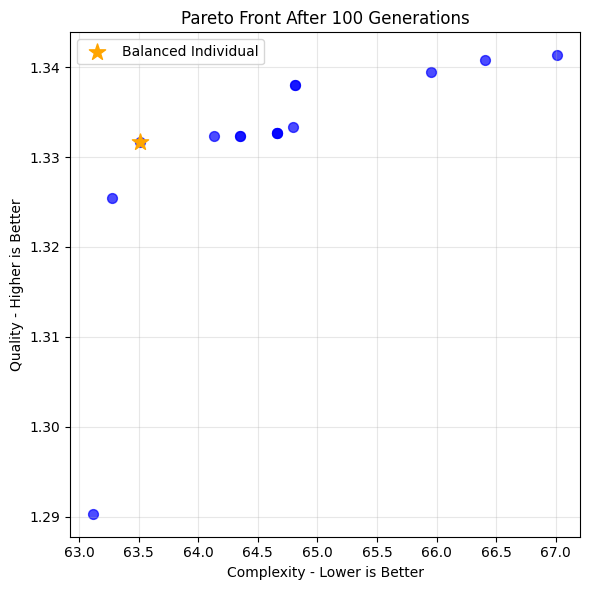

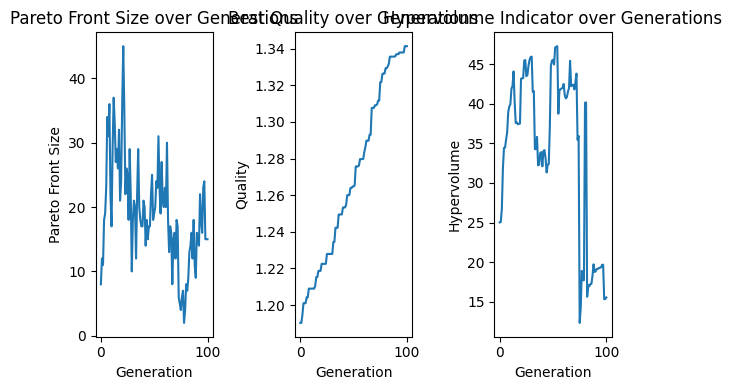

In [20]:
# Plot Pareto Front
import matplotlib.pyplot as plt

pareto = result['pareto_front']
qualities = [p['quality'] for p in pareto]
complexities = [p['complexity'] for p in pareto]

plt.figure(figsize=(6, 6))
plt.scatter(complexities, qualities, c='blue', s=50, alpha=0.7)

# Highlight special solutions
# plt.scatter([result['best_quality']['complexity']], [result['best_quality']['quality']], 
#             c='green', s=150, marker='*', label='Best Quality', zorder=5)
# plt.scatter([result['best_complexity']['complexity']], [result['best_complexity']['quality']], 
#             c='red', s=150, marker='*', label='Best Complexity', zorder=5)
plt.scatter([result['balanced']['complexity']], [result['balanced']['quality']], 
            c='orange', s=150, marker='*', label='Balanced Individual', zorder=5)

plt.xlabel('Complexity - Lower is Better')
plt.ylabel('Quality - Higher is Better')
plt.title("Pareto Front After 100 Generations")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot convergence history
fig, axes = plt.subplots(1, 3, figsize=(6, 4))

history = result['history']
axes[0].plot(history['generation'], history['pareto_front_size'])
axes[0].set_xlabel('Generation')
axes[0].set_ylabel('Pareto Front Size')
axes[0].set_title('Pareto Front Size over Generations')

axes[1].plot(history['generation'], history['best_quality'], label='Best Quality')
axes[1].set_xlabel('Generation')
axes[1].set_ylabel('Quality')
axes[1].set_title('Best Quality over Generations')

axes[2].plot(history['generation'], history['hypervolume'])
axes[2].set_xlabel('Generation')
axes[2].set_ylabel('Hypervolume')
axes[2].set_title('Hypervolume Indicator over Generations')

plt.tight_layout()
plt.show()

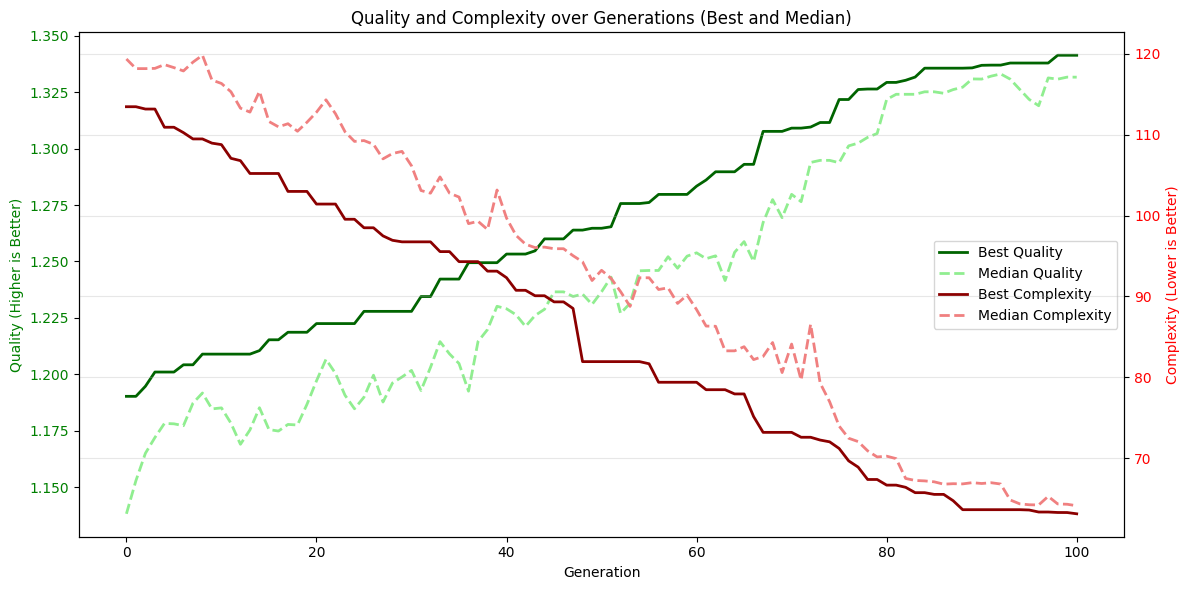

In [15]:
# Plot Best/Mean and Median Quality/Complexity over Generations
import matplotlib.pyplot as plt

history = result['history']

fig, ax = plt.subplots(figsize=(12, 6))

# Quality (higher is better) - use left y-axis
ax.plot(history['generation'], history['best_quality'], label='Best Quality', color='darkgreen', linewidth=2)
ax.plot(history['generation'], history['median_quality'], label='Median Quality', color='lightgreen', linewidth=2, linestyle='--')
ax.set_xlabel('Generation')
ax.set_ylabel('Quality (Higher is Better)', color='green')
ax.tick_params(axis='y', labelcolor='green')

# Complexity (lower is better) - use right y-axis
ax2 = ax.twinx()
ax2.plot(history['generation'], history['best_complexity'], label='Best Complexity', color='darkred', linewidth=2)
ax2.plot(history['generation'], history['median_complexity'], label='Median Complexity', color='lightcoral', linewidth=2, linestyle='--')
ax2.set_ylabel('Complexity (Lower is Better)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add legends
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='center right')

plt.title('Quality and Complexity over Generations (Best and Median)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [21]:
# Create graph files from EA result
from experiments.create_graph_files_ea import create_graph_files_from_ea_result

slug = f"{base_name}_ea"
graph_file_dir = './graph_files'

create_graph_files_from_ea_result(
    graph_or_path=graph,
    ea_result=result['best_complexity'],
    slug=slug,
    output_path=graph_file_dir
)

print(f"Graph files created in {graph_file_dir}/{slug}.json")

# Create graph files (baseline, default pruning)
slug = f"{base_name}_baseline"  # this is the name that you assign to the graph
graph_file_dir = './graph_files'  # where to write the graph files. no need to make this one; create_graph_files does that for you
node_threshold=0.8  # keep only the minimum # of nodes whose cumulative influence is >= 0.8
edge_threshold=0.98  # keep only the minimum # of edges whose cumulative influence is >= 0.98

create_graph_files(
    graph_or_path=graph,
    slug=slug,
    output_path=graph_file_dir,
    node_threshold=node_threshold,
    edge_threshold=edge_threshold
)
print(f"Graph files created in {graph_file_dir}/{slug}.json")


Graph files created in ./graph_files/war_ea.json
pruning graph
Graph files created in ./graph_files/war_baseline.json
Graph files created in ./graph_files/war_baseline.json


In [10]:
# evaluate baseline graph
from circuit_tracer.graph import compute_graph_scores_masked, prune_graph

node_mask, edge_mask, cumulative_scores = prune_graph(graph, node_threshold, edge_threshold)
print(f"Baseline pruned graph scores:   {compute_graph_scores_masked(graph, node_mask, edge_mask)}")

pruning graph
Baseline pruned graph scores:   (0.578798770904541, 0.8821017742156982)
Baseline pruned graph scores:   (0.578798770904541, 0.8821017742156982)


In [22]:
from experiments.algorithm1 import GraphPrunerEA, create_individual
import torch

ea = GraphPrunerEA(graph, hp)

# Create an individual with uniform thresholds matching prune_graph settings
# node_threshold=0.8, edge_threshold=0.98 from cell 11
n_layers = graph.cfg.n_layers
device = graph.adjacency_matrix.device

individual = create_individual(
    node_thresholds=[node_threshold] * n_layers,  # 0.8 for all layers
    edge_thresholds=[edge_threshold] * n_layers,  # 0.98 for all layers
    device=device
)

# Evaluate the individual
ea.evaluate(individual)

print(f"Individual based on prune_graph thresholds:")
print(f"  Node threshold: {node_threshold}, Edge threshold: {edge_threshold}")
print(f"  Quality: {individual.objectives[0]:.4f}, Complexity: {individual.objectives[1]:.4f}")
print(f"  Completeness: {individual.completeness:.4f}, Replacement: {individual.replacement:.4f}")
print(f"  Nodes: {individual.n_nodes}, Edges: {individual.n_edges}")

MultiGPUGraphEvaluator initialized with 4 GPUs: [0, 1, 2, 3]
  Max batch per GPU: 8
Precomputing graph influence scores...
Individual based on prune_graph thresholds:
  Node threshold: 0.8, Edge threshold: 0.98
  Quality: 1.1676, Complexity: 124.5609
  Completeness: 0.9197, Replacement: 0.7078
  Nodes: 3396, Edges: 2897971
Individual based on prune_graph thresholds:
  Node threshold: 0.8, Edge threshold: 0.98
  Quality: 1.1676, Complexity: 124.5609
  Completeness: 0.9197, Replacement: 0.7078
  Nodes: 3396, Edges: 2897971


In [26]:
from circuit_tracer.frontend.local_server import serve

port = 8194
server = serve(data_dir='./graph_files/', port=port)

from IPython.display import IFrame
display(IFrame(src=f'http://localhost:{port}/index.html', width='100%', height='800px'))


In [25]:
server.stop()